# Problem

With overall increasing life expectancies and low fertility rates, the proportion of Singapore’s population aged 65 years and above is rising rapidly, with large cohorts of “baby boomers” entering the age range of 65 and above. 25% of the population is predicted to be aged 65 and above by 2030, which is almost double that of the 14.4% that was recorded in 2019. 

As such, it is evident that healthcare quality is of paramount importance. Models that predict in-hospital mortality can assist with patients’ risk stratification, allowing for better level of care placement, closer follow-up, and improved health care quality. We would like to find out:

### How can hospitals predict the survival outcome of their in-hospital patients ? 

# Libraries

In [285]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier

In [286]:
df = pd.read_csv('Hospital Mortality.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

# Data Cleaning
### Dealing with NULL values

In [287]:
df.isna().sum()

group                         0
ID                            0
outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophil

From the above, since only one row has a missing 'outcome' value, we will drop that row.

In [288]:
df = df.dropna(subset=['outcome'])

<AxesSubplot:>

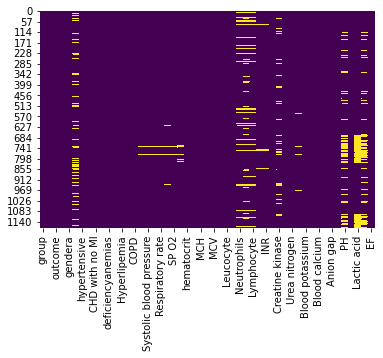

In [289]:
sb.heatmap(df.isnull(),cbar=False,cmap='viridis')

There are many missing values in BMI, Neutrophils, Basophils, Lymphocyte, Creatine kinase, PH, Lactic acid, PCO2, while other columns have fewer missing values. We can’t drop these columns as it may be important for our prediction. Hence, we will fill missing values with the mean.

In [290]:
#Filling NaN with mean
df = df.fillna(df.mean())
df.isna().sum()

group                       0
ID                          0
outcome                     0
age                         0
gendera                     0
BMI                         0
hypertensive                0
atrialfibrillation          0
CHD with no MI              0
diabetes                    0
deficiencyanemias           0
depression                  0
Hyperlipemia                0
Renal failure               0
COPD                        0
heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
hematocrit                  0
RBC                         0
MCH                         0
MCHC                        0
MCV                         0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Basophils                   0
Lymphocyte                  0
PT        

### Renaming Columns

We are renaming columns and removing columns like 'group' and 'ID' that do not affect the outcome.

In [291]:
df.rename(columns = {'gendera':'gender'}, inplace = True)
df = df.drop(columns=['group', 'ID'])
df['outcome'] = df['outcome'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1176
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   1176 non-null   int64  
 1   age                       1176 non-null   int64  
 2   gender                    1176 non-null   int64  
 3   BMI                       1176 non-null   float64
 4   hypertensive              1176 non-null   int64  
 5   atrialfibrillation        1176 non-null   int64  
 6   CHD with no MI            1176 non-null   int64  
 7   diabetes                  1176 non-null   int64  
 8   deficiencyanemias         1176 non-null   int64  
 9   depression                1176 non-null   int64  
 10  Hyperlipemia              1176 non-null   int64  
 11  Renal failure             1176 non-null   int64  
 12  COPD                      1176 non-null   int64  
 13  heart rate                1176 non-null   float64
 14  Systolic

### Feature Selection: Pairwise Correlation

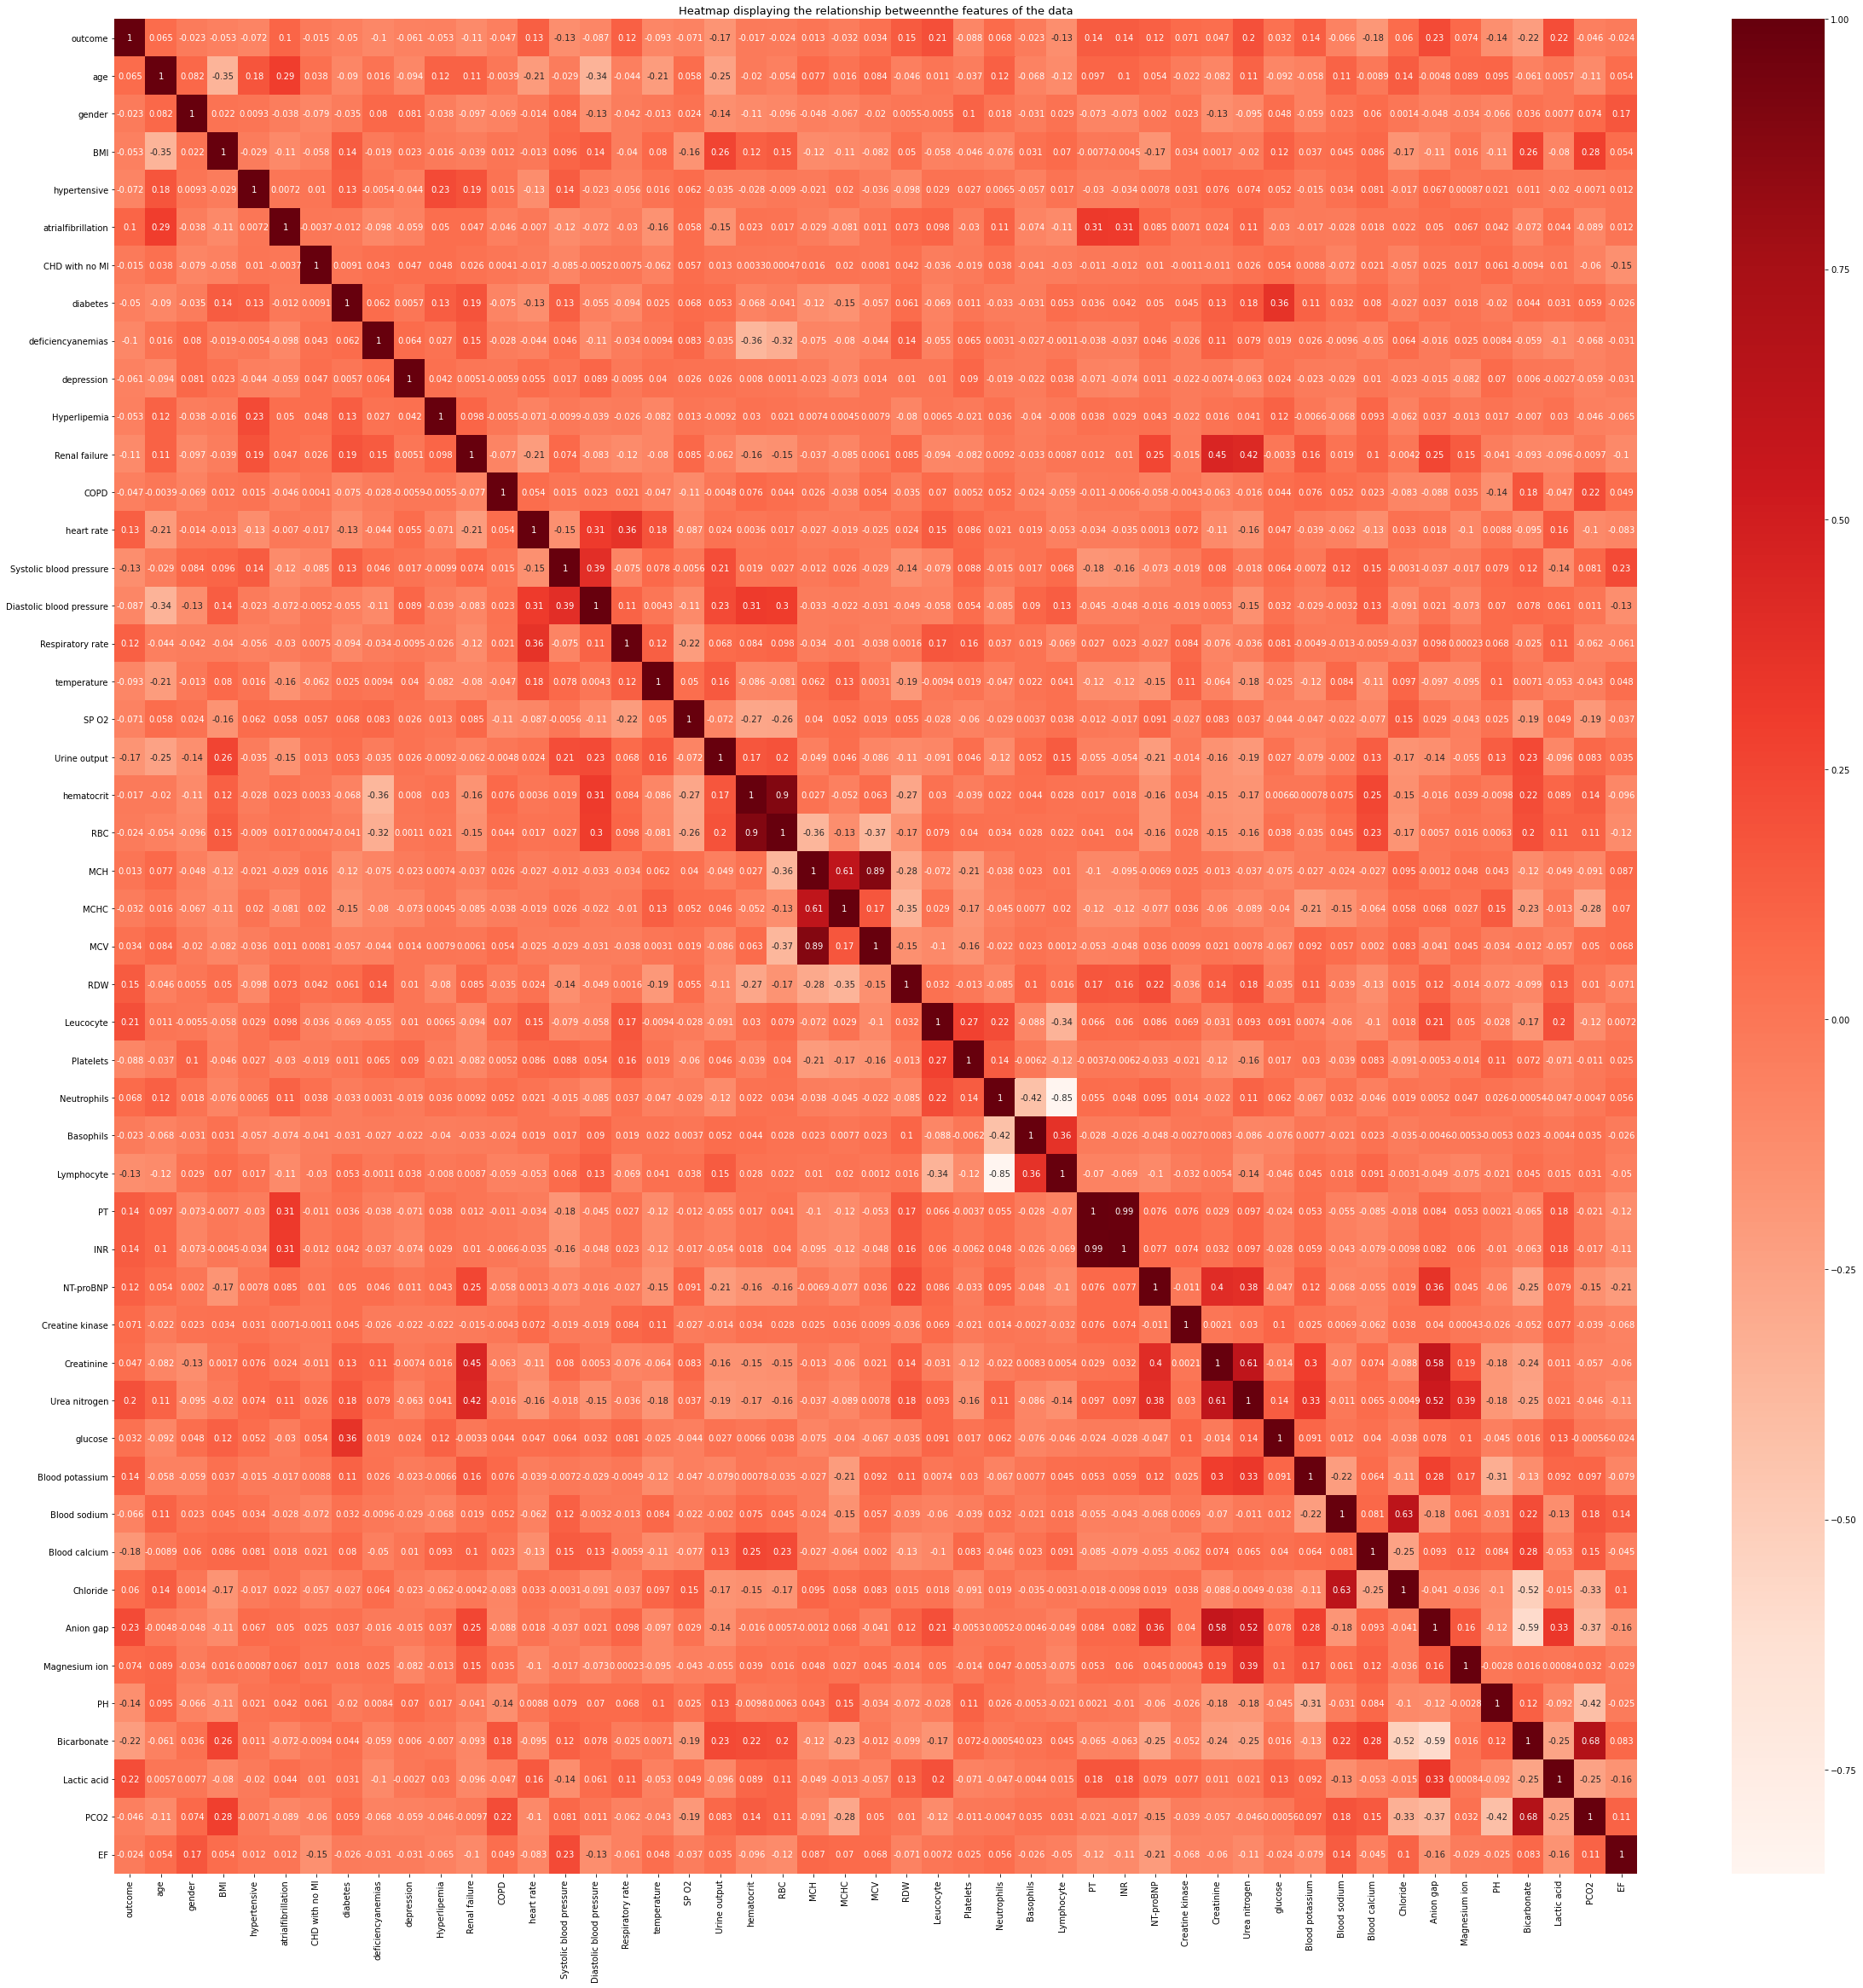

In [292]:
plt.figure(figsize=(40, 40))
X = df.iloc[:, 1:48]
y = df.iloc[:, 0]
sb.heatmap(df.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship betweennthe features of the data',
         fontsize=13)
plt.show()

#### 1. Identify pairs of correlated variables

From the heatmap, we can tell that variables 'hematocrit' and 'RBC', 'MCH' and 'MCV', 'INR' and 'PT' are highly correlated, with correlation value of 0.9, 0.89 and 0.99 respectively. 

#### 2. Discard variable with weaker correlation with the target

'hematocrit'(-0.017) and 'RBC'(-0.024): discard 'hematocrit'

'MCH'(-0.013) and 'MCV'(-0.034): discard 'MCH'

'INR'(0.14) and 'PT'(0.14): discard either

In [293]:
df = df.drop(columns=['hematocrit', 'MCH', 'INR'])

### Feature Selection: Low Variance Filter

Drop or review variables that have a very low variation. Variables below have higher variance.

In [294]:
from sklearn.preprocessing import normalize
normalize = normalize(df)
data_scaled = pd.DataFrame(normalize)
variance = data_scaled.var()
columns = df.columns

#saving the names of variables having variance more than a threshold value

variable = ['outcome']

for i in range(0,len(variance)):
    if variance[i]>=0.0001:
        variable.append(columns[i])

df = df[variable]
variable

['outcome',
 'age',
 'heart rate',
 'Systolic blood pressure',
 'Diastolic blood pressure',
 'SP O2',
 'Urine output',
 'MCV',
 'Platelets',
 'Neutrophils',
 'NT-proBNP',
 'Creatine kinase',
 'glucose',
 'Blood sodium',
 'Chloride',
 'EF']

List of final variables used:

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1176
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   outcome                   1176 non-null   int64  
 1   age                       1176 non-null   int64  
 2   heart rate                1176 non-null   float64
 3   Systolic blood pressure   1176 non-null   float64
 4   Diastolic blood pressure  1176 non-null   float64
 5   SP O2                     1176 non-null   float64
 6   Urine output              1176 non-null   float64
 7   MCV                       1176 non-null   float64
 8   Platelets                 1176 non-null   float64
 9   Neutrophils               1176 non-null   float64
 10  NT-proBNP                 1176 non-null   float64
 11  Creatine kinase           1176 non-null   float64
 12  glucose                   1176 non-null   float64
 13  Blood sodium              1176 non-null   float64
 14  Chloride

# EDA

<AxesSubplot:xlabel='EF', ylabel='Count'>

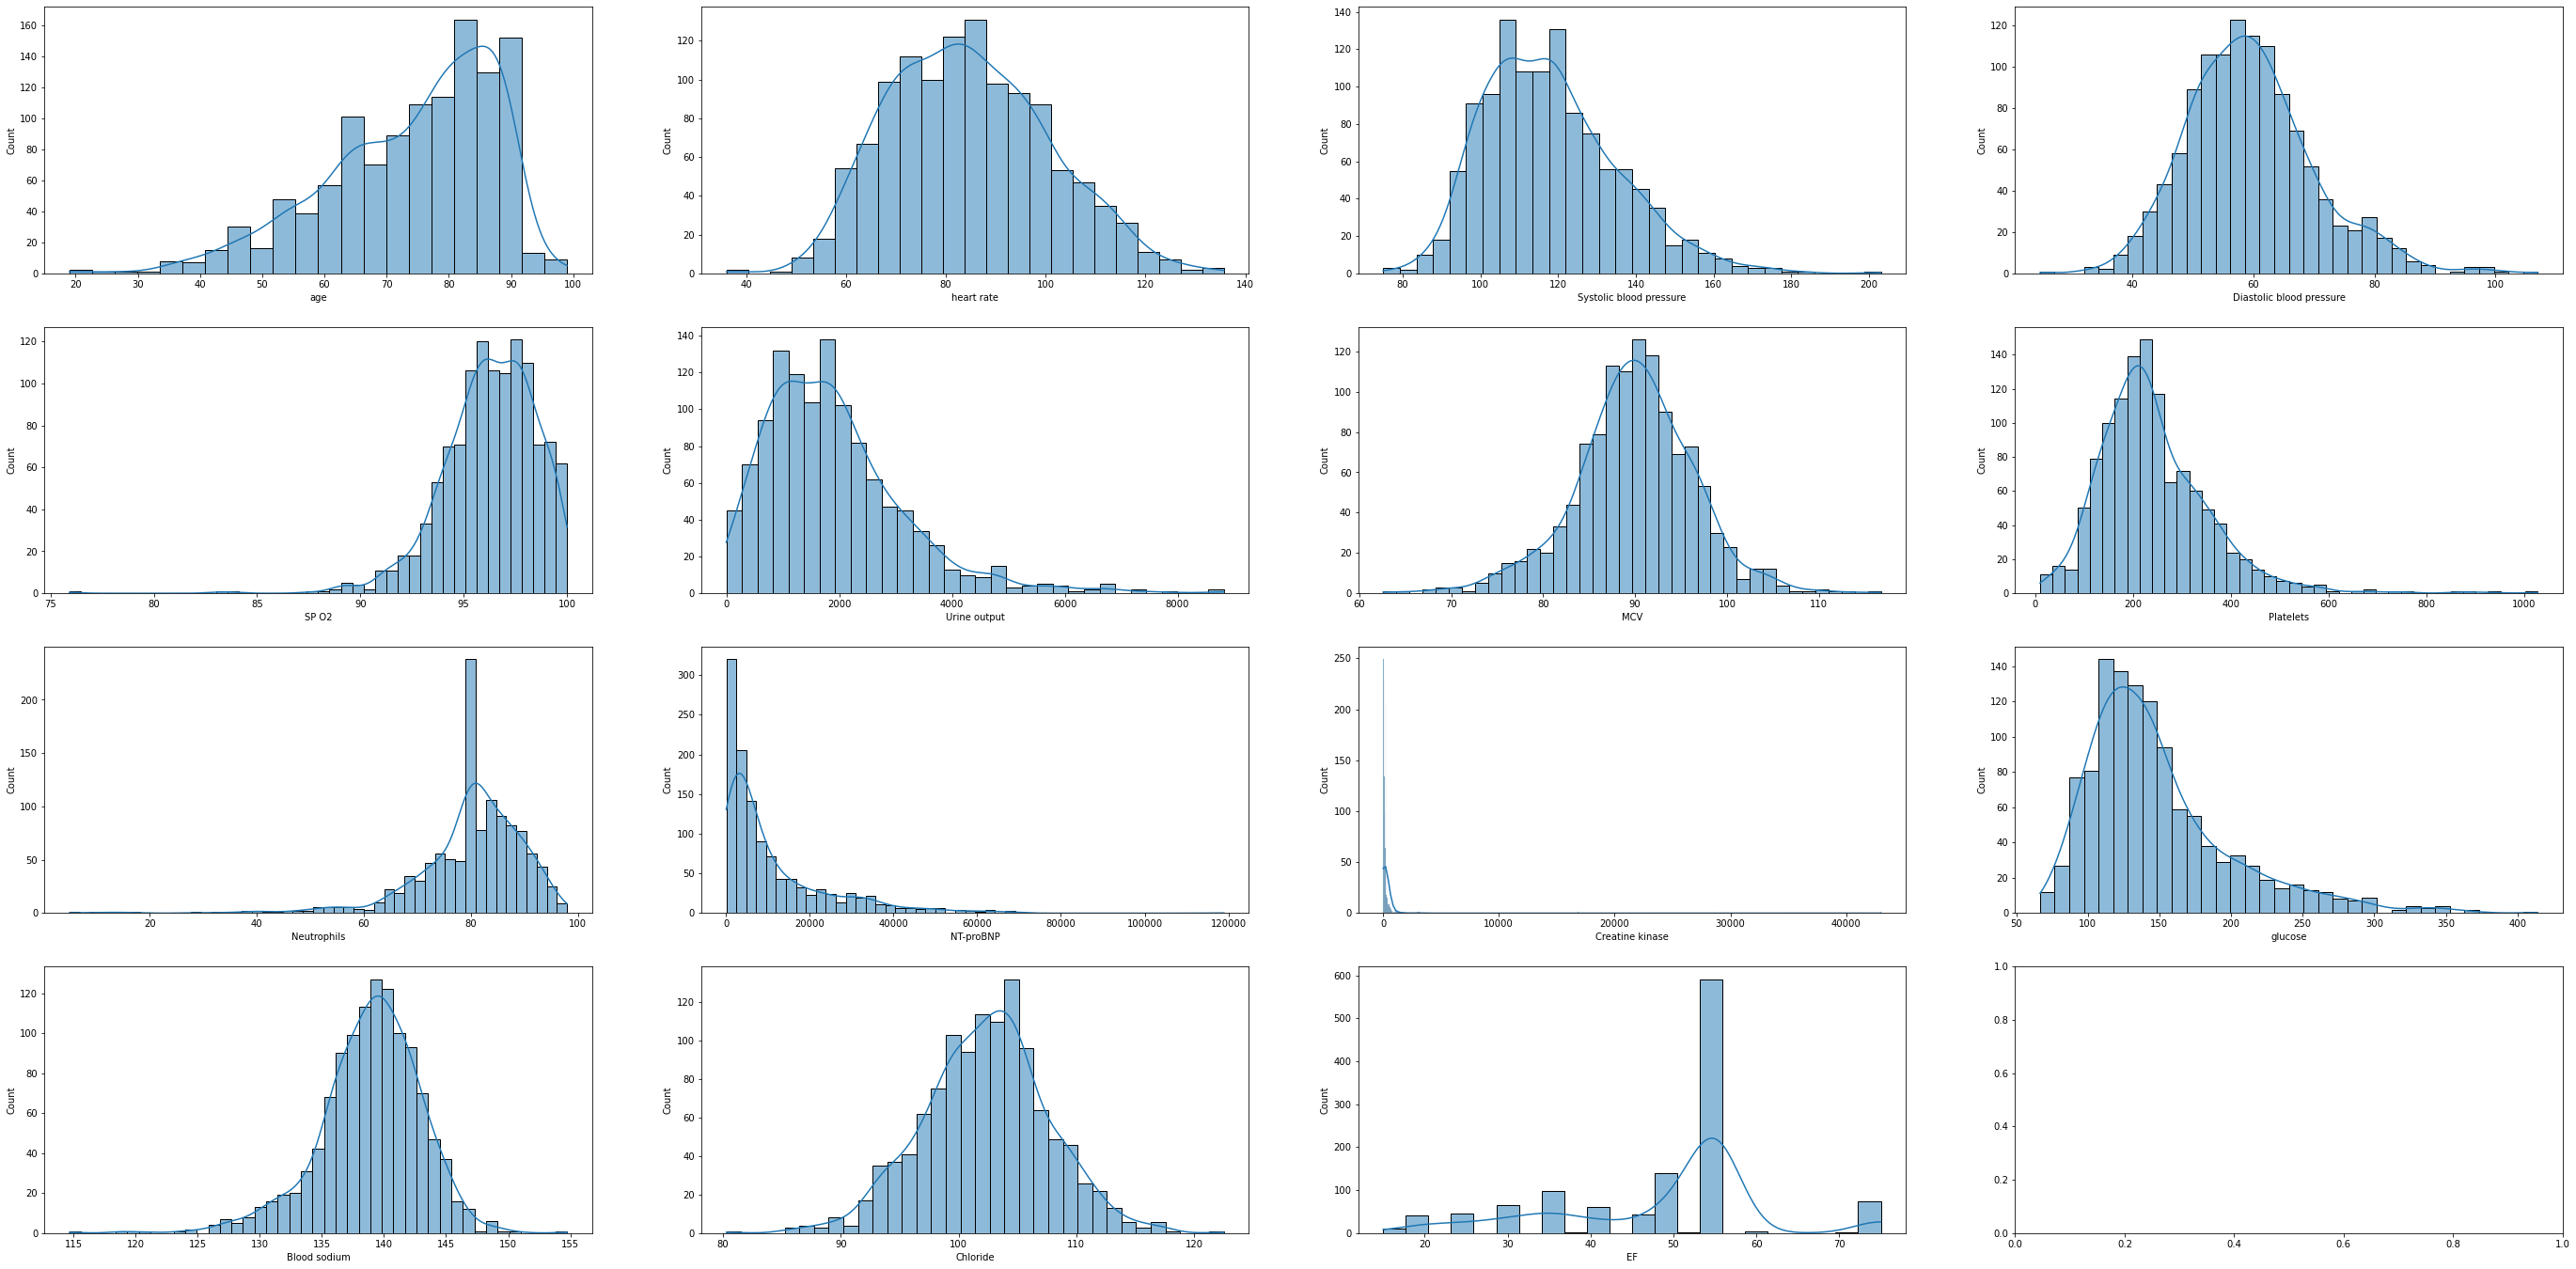

In [296]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(4, 4, figsize=(48, 24))

# Plot the basic uni-variate figure
sb.histplot(data=df, x="age", kde=True, ax = axes[0,0])
sb.histplot(data=df, x="heart rate", kde=True, ax = axes[0,1])
sb.histplot(data=df, x="Systolic blood pressure", kde=True, ax = axes[0,2])
sb.histplot(data=df, x="Diastolic blood pressure", kde=True, ax = axes[0,3])
sb.histplot(data=df, x="SP O2",kde=True, ax = axes[1,0])
sb.histplot(data=df, x="Urine output",kde=True, ax = axes[1,1])
sb.histplot(data=df, x="MCV", kde=True, ax = axes[1,2])
sb.histplot(data=df, x="Platelets",kde=True, ax = axes[1,3])
sb.histplot(data=df, x="Neutrophils",kde=True, ax = axes[2,0])
sb.histplot(data=df, x="NT-proBNP",kde=True, ax = axes[2,1])
sb.histplot(data=df, x="Creatine kinase",kde=True, ax = axes[2,2])
sb.histplot(data=df, x="glucose",kde=True, ax = axes[2,3])
sb.histplot(data=df, x="Blood sodium",kde=True, ax = axes[3,0])
sb.histplot(data=df, x="Chloride",kde=True, ax = axes[3,1])
sb.histplot(data=df, x="EF",kde=True, ax = axes[3,2])

## Uni-Variate Findings
#### Age
From the above, we can tell that the in-hospital ICU patients increases as age increases, with a large number between the ages of 80 to 90.
#### Heart Rate
While most of the heart rate values lie between 70 - 90, there are some who can go as low as 40 or as high as 130.
#### Systolic Blood Pressure
While most values lie between 110-120, there are some who can go as high as 200. 
#### Diastolic Blood Pressure
Most values are around 60.
#### SPO2
Most patients have SPO2 values of around 95 to 97
#### Urine Output
While most values lie between 1000 to 2000, there are some outliers who can go as high as 8000.
#### Neutrophils
Most common value would be 80.
#### NT-proBNP
Most patients have very low levels of NT-proBNP.
#### Creatine Kinase
While most values are low, there are a few outliers that have extremely high levels of creatine kinase, that could be potentially dangerous. 
#### Glucose
Most glucose levels are at 125.
#### Blood Sodium
Most blood sodium levels are at 140
#### Chloride
Most chloride levels are at 102.
#### EF
There is no pattern for EF values, but we can observe that most are at 55.

<AxesSubplot:xlabel='outcome', ylabel='EF'>

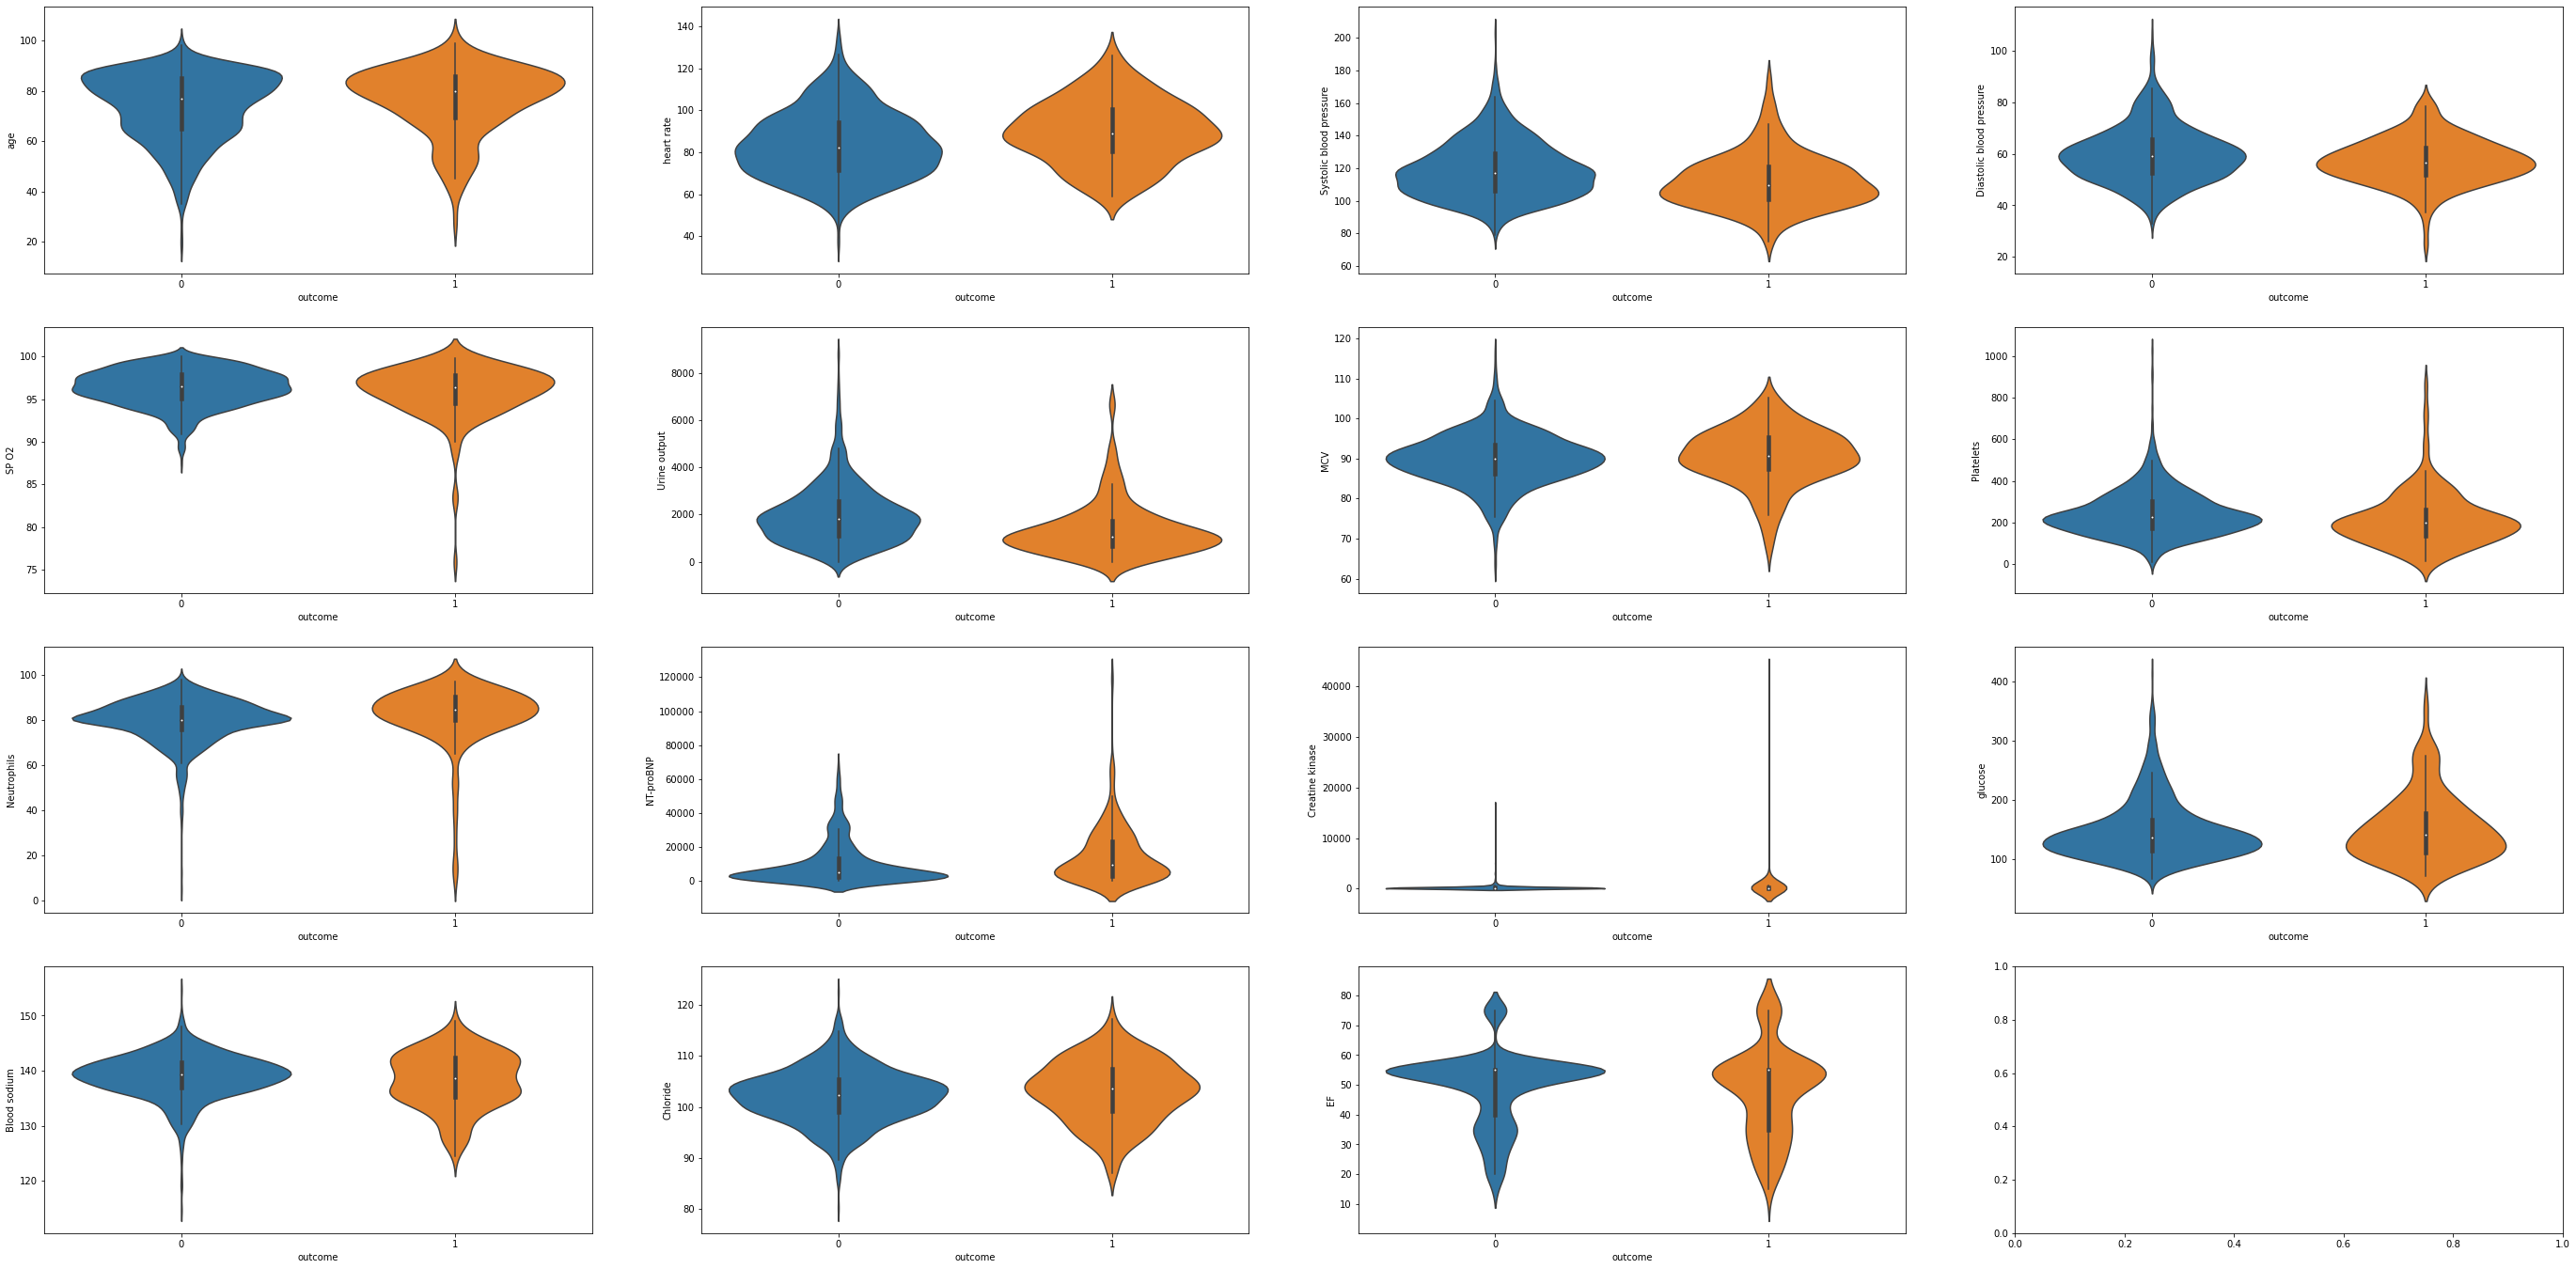

In [297]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(4, 4, figsize=(48, 24))

# Plot the basic uni-variate figure
sb.violinplot(data=df, x="outcome", y="age",  kde=True, ax = axes[0,0])
sb.violinplot(data=df, x="outcome", y="heart rate", kde=True, ax = axes[0,1])
sb.violinplot(data=df, x="outcome", y="Systolic blood pressure", kde=True, ax = axes[0,2])
sb.violinplot(data=df, x="outcome", y="Diastolic blood pressure", kde=True, ax = axes[0,3])
sb.violinplot(data=df, x="outcome", y="SP O2",kde=True, ax = axes[1,0])
sb.violinplot(data=df, x="outcome", y="Urine output",kde=True, ax = axes[1,1])
sb.violinplot(data=df, x="outcome", y="MCV", kde=True, ax = axes[1,2])
sb.violinplot(data=df, x="outcome", y="Platelets",kde=True, ax = axes[1,3])
sb.violinplot(data=df, x="outcome", y="Neutrophils",kde=True, ax = axes[2,0])
sb.violinplot(data=df, x="outcome", y="NT-proBNP",kde=True, ax = axes[2,1])
sb.violinplot(data=df, x="outcome", y="Creatine kinase",kde=True, ax = axes[2,2])
sb.violinplot(data=df, x="outcome", y="glucose",kde=True, ax = axes[2,3])
sb.violinplot(data=df, x="outcome", y="Blood sodium",kde=True, ax = axes[3,0])
sb.violinplot(data=df, x="outcome", y="Chloride",kde=True, ax = axes[3,1])
sb.violinplot(data=df, x="outcome", y="EF",kde=True, ax = axes[3,2])

<AxesSubplot:xlabel='outcome', ylabel='EF'>

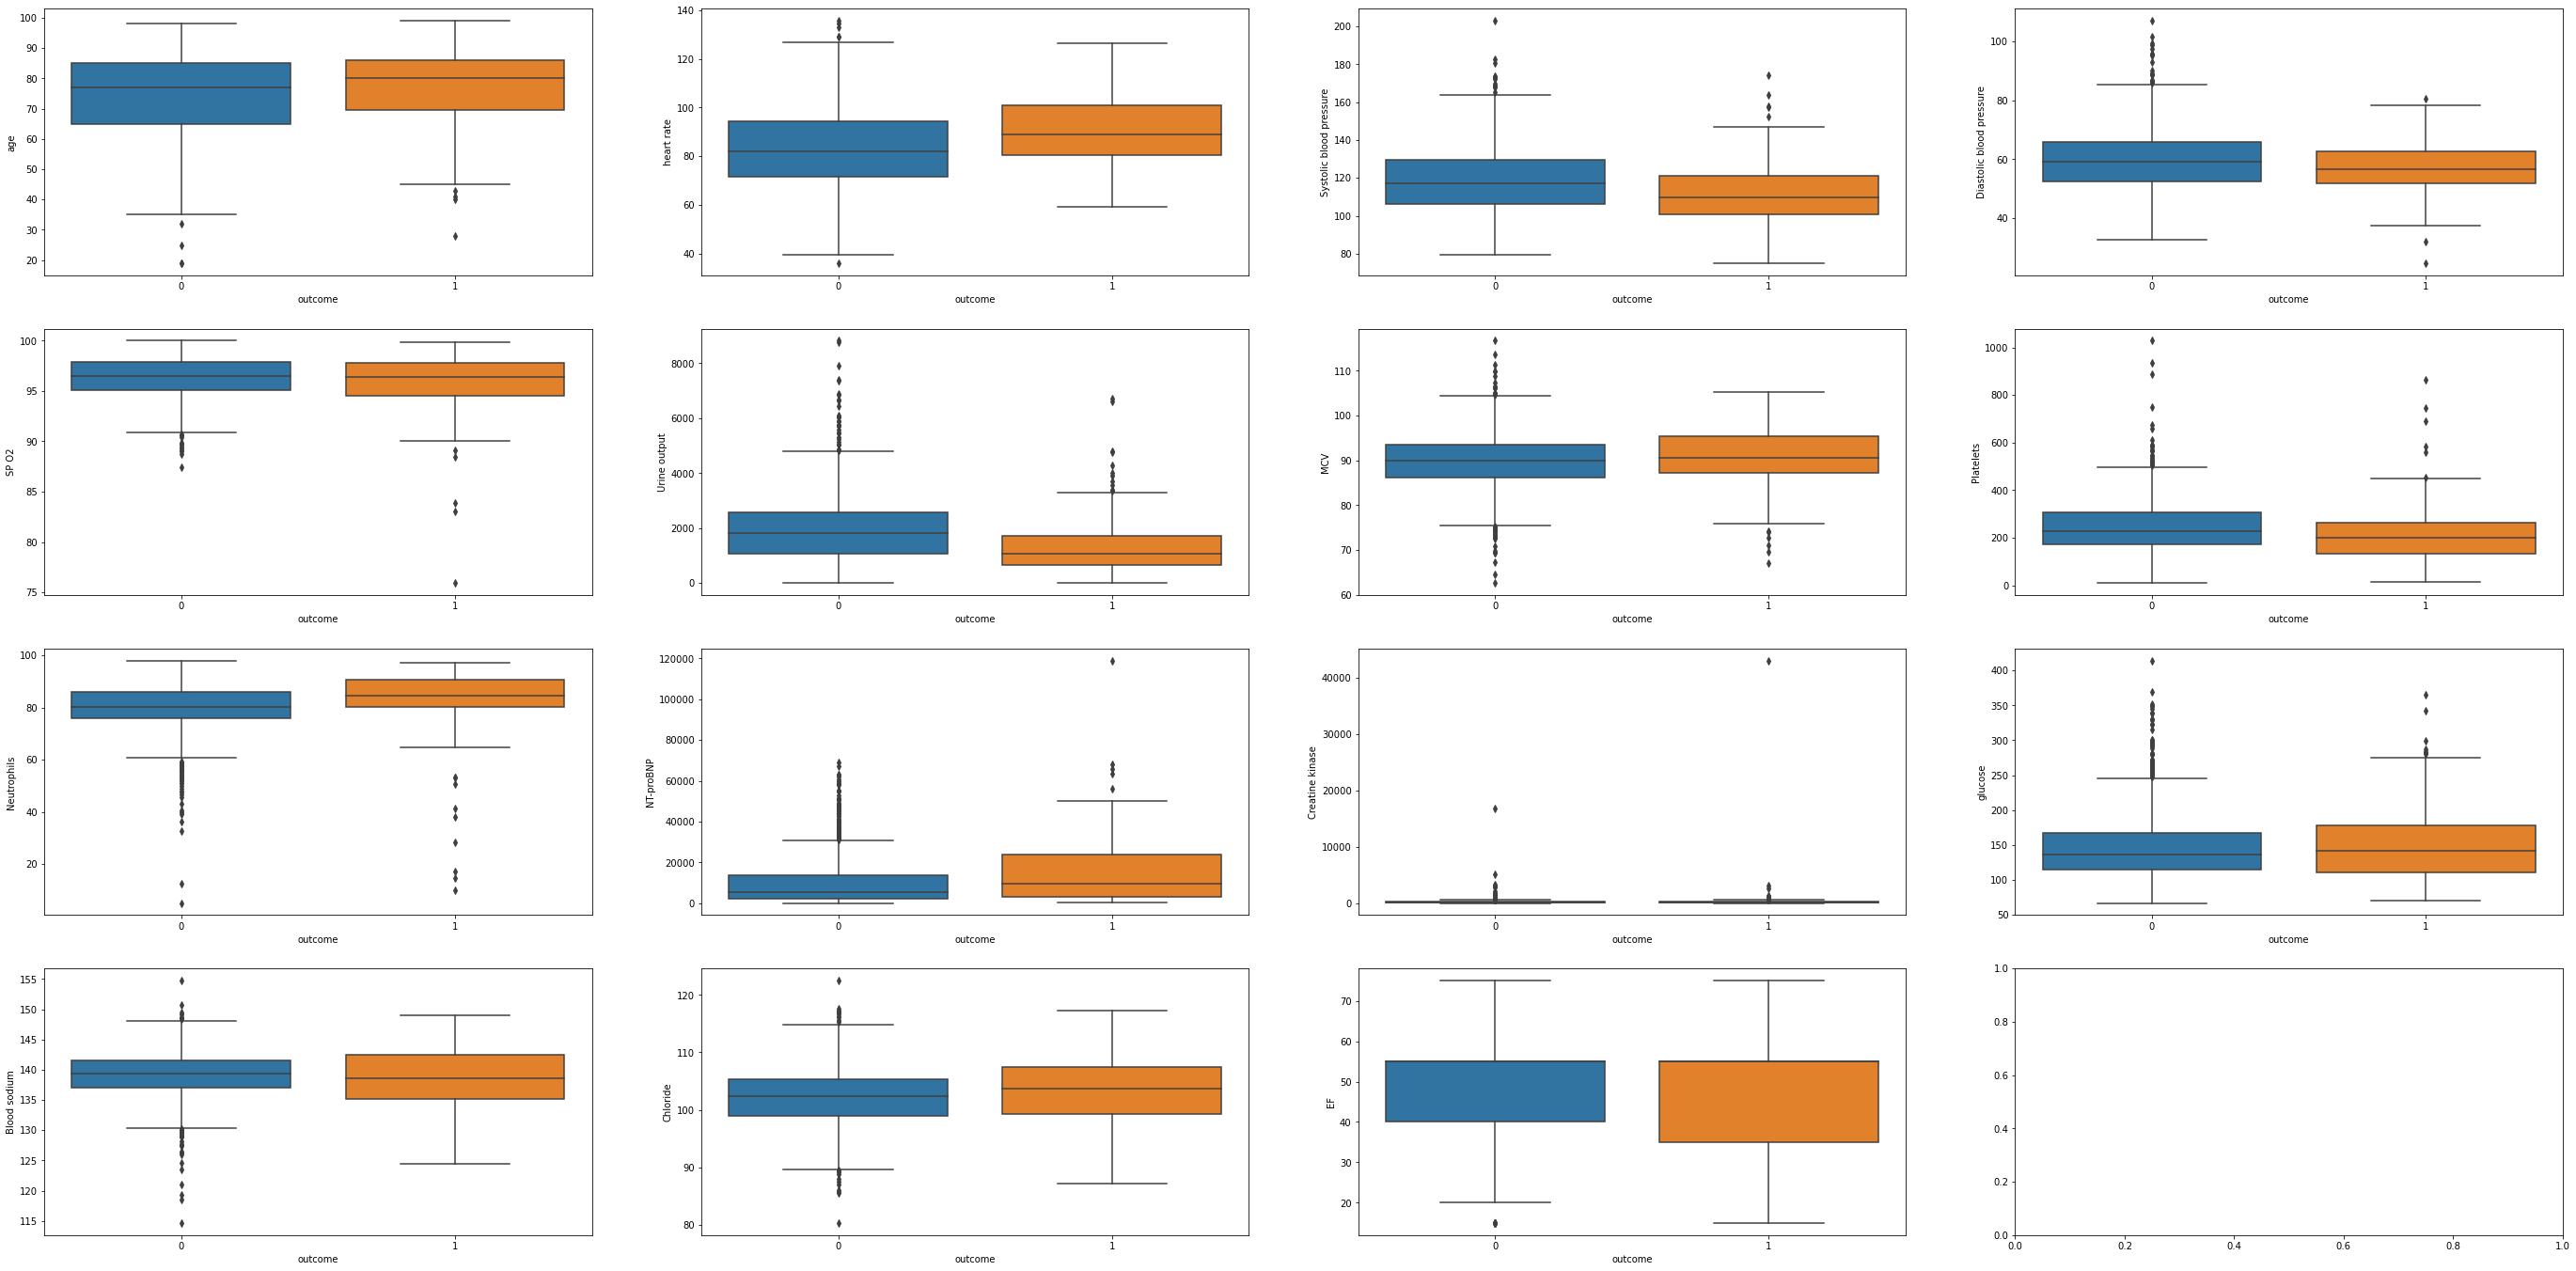

In [298]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(4, 4, figsize=(48, 24))

# Plot the basic uni-variate figure
sb.boxplot(data=df, x="outcome", y="age", ax = axes[0,0])
sb.boxplot(data=df, x="outcome", y="heart rate", ax = axes[0,1])
sb.boxplot(data=df, x="outcome", y="Systolic blood pressure", ax = axes[0,2])
sb.boxplot(data=df, x="outcome", y="Diastolic blood pressure",  ax = axes[0,3])
sb.boxplot(data=df, x="outcome", y="SP O2", ax = axes[1,0])
sb.boxplot(data=df, x="outcome", y="Urine output", ax = axes[1,1])
sb.boxplot(data=df, x="outcome", y="MCV", ax = axes[1,2])
sb.boxplot(data=df, x="outcome", y="Platelets", ax = axes[1,3])
sb.boxplot(data=df, x="outcome", y="Neutrophils", ax = axes[2,0])
sb.boxplot(data=df, x="outcome", y="NT-proBNP", ax = axes[2,1])
sb.boxplot(data=df, x="outcome", y="Creatine kinase", ax = axes[2,2])
sb.boxplot(data=df, x="outcome", y="glucose", ax = axes[2,3])
sb.boxplot(data=df, x="outcome", y="Blood sodium", ax = axes[3,0])
sb.boxplot(data=df, x="outcome", y="Chloride", ax = axes[3,1])
sb.boxplot(data=df, x="outcome", y="EF", ax = axes[3,2])

## Bi-Variate Findings

Despite the presence of extreme outliers in creatine kinase, we have decided to keep those outliers as high levels of creatine kinase is dangerous and will affect mortality rate. Thus, the presence of these outliers could better help in prediction, especially since the outcome is not affected when these outliers are not taken into consideration.  

We have decided to drop EF as there does not seem to be any impact on outcome from the boxplot and violinplot as shown above. 

In [299]:
df = df.drop(columns=['EF'])

<AxesSubplot:>

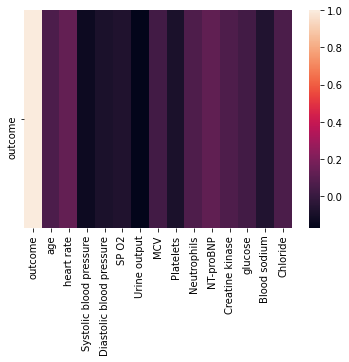

In [300]:
sb.heatmap(df.corr().loc[['outcome'],:])

# Machine Learning: KNN

In [301]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [302]:
#Split Dataset
X = df.iloc[:, 1:48]
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

#Feature Scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Confusion Matrix:
True Positive: 0.0036452004860267314
True Negative: 0.8602673147023087
False Positive: 0.002430133657351154
False Negative: 0.1336573511543135

Accuracy Score: 0.8639125151883353
F1 Score: 0.05084745762711864


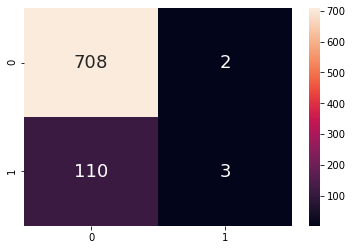

In [303]:
#Define the Model
classifier = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean')
classifier.fit(X_train, y_train)

#Predict the Train Set Results
y_train_pred = classifier.predict(X_train)

#Evaluate the Model
print("Confusion Matrix:")
cm = confusion_matrix(y_train, y_train_pred)

#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

tn, fp, fn, tp = confusion_matrix(list(y_train), list(y_train_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp


print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

#Print Accuracy Score
accuracy = accuracy_score(y_train, y_train_pred)
print("\nAccuracy Score:", accuracy)
print("F1 Score:",f1_score(y_train, y_train_pred))

Confusion Matrix:
True Positive: 0.0
True Negative: 0.8696883852691218
False Positive: 0.0
False Negative: 0.13031161473087818

Accuracy Score: 0.8696883852691218
F1 Score: 0.0


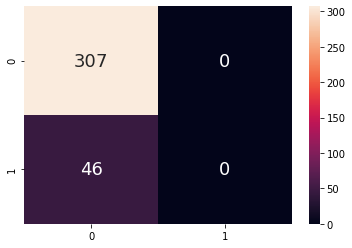

In [304]:
#Predict the Test Set Results
classifier.fit(X_test, y_test)
y_test_pred = classifier.predict(X_test)

#Evaluate the Model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)

#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_test_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp


print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

#Print Accuracy Score
accuracy = accuracy_score(y_test, y_test_pred)
print("\nAccuracy Score:", accuracy)
print("F1 Score:",f1_score(y_test, y_test_pred))

# Machine Learning: Logistic Regression

In [305]:
#import required modules
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

In [306]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)

In [307]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cnf_matrix

array([[705,   5],
       [106,   7]], dtype=int64)

True Positive: 0.00850546780072904
True Negative: 0.8566221142162819
False Positive: 0.006075334143377886
False Negative: 0.12879708383961117
Accuracy: 0.8651275820170109
F1 Score: 0.112


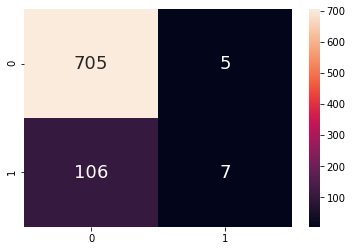

In [308]:
#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

tn, fp, fn, tp = confusion_matrix(list(y_train), list(y_train_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp

print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("F1 Score:",f1_score(y_train, y_train_pred))

True Positive: 0.0169971671388102
True Negative: 0.8640226628895185
False Positive: 0.0056657223796034
False Negative: 0.11331444759206799
Accuracy: 0.8810198300283286
F1 Score: 0.22222222222222218


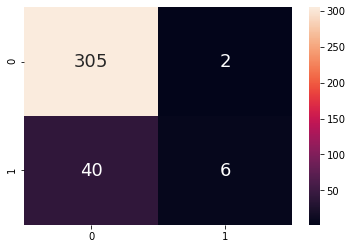

In [309]:
logreg.fit(X_test, y_test)

y_test_pred = logreg.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_test_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp

print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("F1 Score:",f1_score(y_test, y_test_pred))

# Machine Learning: Random Forest


In [310]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:48]
y = df.iloc[:, 0]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [311]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
randomforestclf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets 
randomforestclf.fit(X_train,y_train)

y_train_pred = randomforestclf.predict(X_train)

<AxesSubplot:>

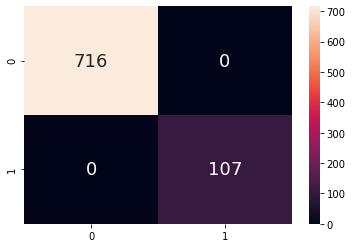

In [312]:
#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

In [313]:
tn, fp, fn, tp = confusion_matrix(list(y_train), list(y_train_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp


print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

True Positive: 0.13001215066828675
True Negative: 0.8699878493317132
False Positive: 0.0
False Negative: 0.0


In [314]:
print("Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("F1 Score:",f1_score(y_train, y_train_pred))

Accuracy: 1.0
F1 Score: 1.0


An accuracy of 100% tells us that it is a pretty fair fit in the model.

[Text(787.8978924418604, 1319.0294117647059, 'X[9] <= 22609.0\ngini = 0.239\nsamples = 513\nvalue = [709, 114]'),
 Text(451.14462209302326, 1239.0882352941176, 'X[7] <= 126.2\ngini = 0.189\nsamples = 436\nvalue = [628, 74]'),
 Text(97.32558139534883, 1159.1470588235295, 'X[11] <= 82.75\ngini = 0.462\nsamples = 48\nvalue = [53, 30]'),
 Text(43.25581395348837, 1079.2058823529412, 'X[11] <= 77.062\ngini = 0.18\nsamples = 5\nvalue = [1, 9]'),
 Text(21.627906976744185, 999.2647058823529, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(64.88372093023256, 999.2647058823529, 'gini = 0.0\nsamples = 4\nvalue = [0, 9]'),
 Text(151.3953488372093, 1079.2058823529412, 'X[1] <= 97.664\ngini = 0.41\nsamples = 43\nvalue = [52, 21]'),
 Text(108.13953488372093, 999.2647058823529, 'X[5] <= 1057.5\ngini = 0.274\nsamples = 32\nvalue = [46, 9]'),
 Text(86.51162790697674, 919.3235294117648, 'X[4] <= 96.223\ngini = 0.498\nsamples = 10\nvalue = [8, 9]'),
 Text(64.88372093023256, 839.3823529411765, 'gini = 0.0

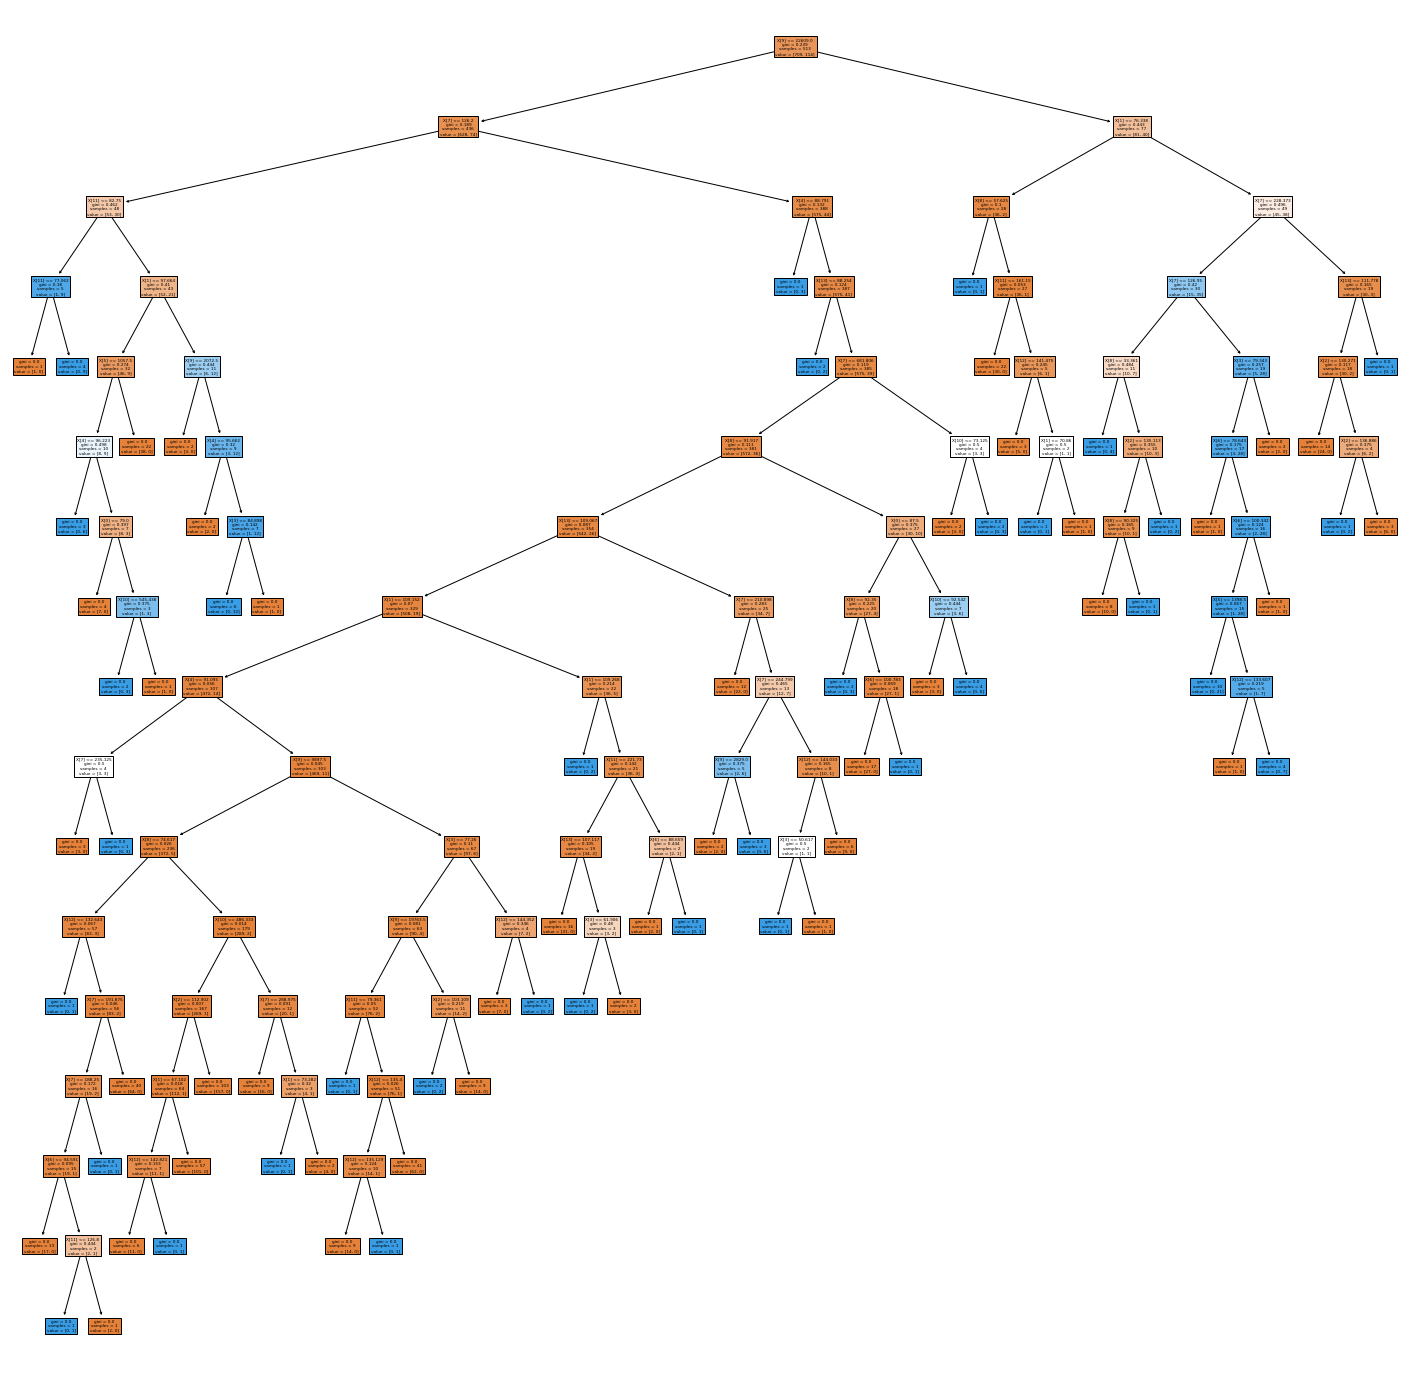

In [315]:
#plot one of the decision trees
from sklearn import tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(25,25))

tree.plot_tree(randomforestclf.estimators_[1], filled = True)

In [316]:
randomforestclf.fit(X_test,y_test)
y_test_pred = randomforestclf.predict(X_test)

<AxesSubplot:>

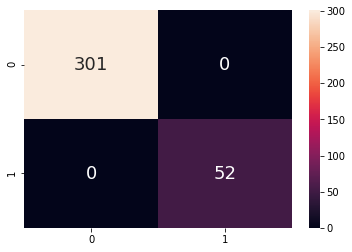

In [317]:
#Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18},)

In [318]:
tn, fp, fn, tp = confusion_matrix(list(y_test), list(y_test_pred), labels=[0, 1]).ravel()
tot = cm.sum()
tot = tn+fp+fn+tp


print("True Positive:", tp/tot)
print("True Negative:", tn/tot)
print("False Positive:", fp/tot)
print("False Negative:", fn/tot)

True Positive: 0.14730878186968838
True Negative: 0.8526912181303116
False Positive: 0.0
False Negative: 0.0


In [319]:
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("F1 Score:",f1_score(y_test, y_test_pred))

Accuracy: 1.0
F1 Score: 1.0


# Conclusion


## ML Models
Of the 3 machine learning models used, random forest has the highest F1 score and accuracy, and thus it is the most ideal method of the 3. 